<a href="https://colab.research.google.com/github/sasan73/Mangaka-Classifier/blob/master/Mangaka_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mangaka** *Classifier*


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time

from PIL import Image
import matplotlib.pyplot as plt

# Data Loading 

In [ ]:
# folder = "Eiichiro Oda"
# file = "one-piece.csv"

In [ ]:
# folder = "Yoshihiro Togashi"
# file = "hunter-x-hunter.csv"

In [ ]:
# folder = "Hajime Isayama"
# file = "shingeki-no-kyojin.csv"

In [ ]:
# folder = "Koyoharu Gotouge"
# file = "kimetsu-no-yaiba.csv"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from pathlib import Path
path = Path('/content/drive/My Drive/Data/Mangaka Classification')

In [ ]:
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [ ]:
# path.ls()

In [ ]:
# download_images??

In [ ]:
# download_images(Path('/content/')/file, dest)

In [ ]:
# for c in classes:
    # print(c)
    # verify_images(path/c, delete=True, max_size=500)

(319, 158)


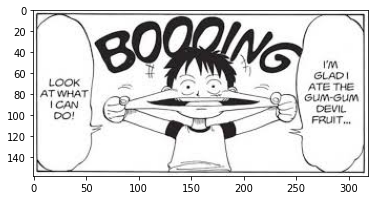

In [ ]:
img = Image.open('/content/drive/My Drive/Data/Mangaka Classification/Eiichiro Oda/00000056.jpg')
plt.imshow(img)
print(img.size)

**Resnet Tranforms**

In [3]:
tfms_train = transforms.Compose([transforms.RandomResizedCrop(335),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

tfms_valid = transforms.Compose([transforms.Resize((335, 335)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

**Costumnet Transforms**

In [ ]:
tfms_train = transforms.Compose([transforms.RandomResizedCrop(335),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(), 
                                transforms.ToTensor(),
                                transforms.Normalize(0, 1)])

tfms_valid = transforms.Compose([transforms.Resize((335, 335)),
                                 transforms.Grayscale(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(0, 1)])

In [4]:
class Mydataset(Dataset):
  def __init__(self, subset, transforms = None):
    self.subset = subset
    self.transforms = transforms
  
  def __getitem__(self, indx):
    x, y = self.subset[indx]
    if self.transforms:  
      x = self.transforms(x)
    return x, y-1
  def __len__(self):
    return len(self.subset)

dataset = datasets.ImageFolder(path)

split_len = [int(len(dataset)* .8), int(len(dataset)* .2)]
train_sub, valid_sub = random_split(dataset, split_len)

torch.manual_seed(13)
train_ds = Mydataset(train_sub, transforms = tfms_train)
valid_ds = Mydataset(valid_sub, transforms = tfms_valid)

In [5]:
batch = 64

In [6]:
train_dl = DataLoader(train_ds, batch_size = batch, shuffle = False, num_workers = 4)
valid_dl = DataLoader(valid_ds, batch_size = batch, shuffle = False, num_workers = 4)

In [53]:
x, y = next(iter(train_dl))
x[0].shape

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f36543fd240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


torch.Size([3, 335, 335])

# Data Visualisation

In [7]:
classes = ['One Piece', 'Attack on Titans', 'Demon Slayer', 'Hunter x Hunter']

In [55]:
# still can be improved
def show_complete_batch(dl, num):
  img, label = next(iter(dl))
  k = 0
  fig, ax = plt.subplots(1, num, figsize = (15, 30))
  fig.tight_layout()
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)# setting margin between subplots to 0
  for i in range(num):
      ax[i].imshow(img[i].permute(1, 2, 0), cmap = 'bone')# 1.if images have three channels use .permute(1, 2, 0)
                                                          # 2.cmap = 'bone' argument added for better depiction of grayscaled images 
      ax[i].tick_params(axis='both', which='both',length=0 ,labelsize = 0) # remove ticks and tick labels
      ax[i].set_title(classes[label[i].item()])

show_complete_batch(train_dl, 5)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f363ffe1358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 
Exception ignored in: <function Wea

Error in callback <function flush_figures at 0x7f36a6301ea0> (for post_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py", line 28, in trigger
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/display.py", line 306, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/formatters.py", line 173, in format
    data = formatter(obj)
  File "<decorator-gen-9>", line 2, in __call__
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/formatters.py", line 217, in catch_format_error
    r = method(

KeyboardInterrupt: ignored

# Costum model

Defining the model. A model with arbitrary architecture constructed by resblocks.

In [ ]:
def conv_layer(in_c, out_c, k, stride=1): return nn.Sequential(nn.Conv2d(in_c, out_c, k, stride, padding=1),
                                          nn.ReLU(),
                                          nn.BatchNorm2d(out_c))



class res_block(nn.Module):
   def __init__(self, c, k):
     super().__init__()
     self.conv1 = conv_layer(c, c, k)
     self.conv2 = conv_layer(c, c, k)
   def forward(self, x): 
     return x + self.conv2(self.conv1(x))



class global_avpool(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x): 
    num_dim = len(x.shape)
    return x.mean([num_dim - 1, num_dim - 2])

In [ ]:
classifier = nn.Sequential(conv_layer(1, 64, 5, stride = 2),
                          res_block(64, 3),
                          nn.MaxPool2d(2, stride = 2, return_indices= True),
                          conv_layer(64, 128, 3, stride= 2),
                          nn.MaxPool2d(2, stride = 2, return_indices= True),
                          res_block(128, 3),
                          global_avpool(),
                          nn.Linear(128, 4))

deconv = nn.Sequential()

In [ ]:
net = manga_net.cuda()

In [ ]:
lr = 1e-2
EPOCH = 6
i = 0
momentum = 0.9 # find a way to implement momentum

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma = 0.1)

In [ ]:
for epoch in range(EPOCH):  # loop over the dataset multiple times
    net.train()
    k = 0
    running_loss_train = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() 


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()

        running_loss_train += loss_train.item()
        k += 1
    print(f'epoch:{epoch}\t\t training_loss: {running_loss_train/ k}')
    
    
    net.eval()
    k = 0     
    running_loss_valid = 0
    corr_cls = 0
    for j, (inputs, labels)  in enumerate(valid_dl):
        with torch.no_grad():
          inputs, labels = inputs.cuda(), labels.cuda()
          outputs = net(inputs)
          loss_valid = criterion(outputs, labels) 
          # calculating evaluation stats
          running_loss_valid += loss_valid.item()
          k += 1
          
          _, preds = torch.max(F.softmax(outputs, 1), 1)
          corr_cls += (preds == labels).sum().item()
                
    print(f'epoch:{epoch}\t\t validation_loss: {running_loss_valid/ k}')
    print(f'epoch:{epoch}\t\t accuracy:{corr_cls * 100 /len(valid_ds)}')   
    print('-' * 20)
    scheduler.step
print('Finished Training')

epoch:0		 training_loss: 1.3286837276659513
epoch:0		 validation_loss: 7.825929927825928
epoch:0		 accuracy:38.095238095238095
--------------------
epoch:1		 training_loss: 1.1343092949766862
epoch:1		 validation_loss: 1.324607014656067
epoch:1		 accuracy:46.59863945578231
--------------------
epoch:2		 training_loss: 1.0927496458354748
epoch:2		 validation_loss: 1.1392229080200196
epoch:2		 accuracy:51.70068027210884
--------------------
epoch:3		 training_loss: 1.0975417996707715
epoch:3		 validation_loss: 1.0550811529159545
epoch:3		 accuracy:58.843537414965986
--------------------
epoch:4		 training_loss: 1.0559044072502537
epoch:4		 validation_loss: 1.170577085018158
epoch:4		 accuracy:53.40136054421769
--------------------
epoch:5		 training_loss: 1.0401988154963444
epoch:5		 validation_loss: 1.0316343784332276
epoch:5		 accuracy:57.142857142857146
--------------------
Finished Training


In [ ]:
PATH = '/content/drive/My Drive/Data/Mangaka Classification/models/stage1.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

# defining a function for model

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#                 dataloaders = train_dl
#             else:
#                 model.eval()   # Set model to evaluate mode
#                 dataloaders = valid_dl

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             if phase == 'train':
#                 epoch_loss = running_loss / len(train_ds) 
#                 epoch_acc = running_corrects.double() / len(train_ds)
#             else:
#                 epoch_loss = running_loss / len(valid_ds) 
#                 epoch_acc = running_corrects.double() / len(valid_ds)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=5);

Epoch 0/4
----------
train Loss: 0.6752 Acc: 0.7355
val Loss: 0.7212 Acc: 0.7517

Epoch 1/4
----------
train Loss: 0.6462 Acc: 0.7330
val Loss: 1.0476 Acc: 0.6497

Epoch 2/4
----------
train Loss: 0.6525 Acc: 0.7355
val Loss: 0.7227 Acc: 0.7517

Epoch 3/4
----------
train Loss: 0.6613 Acc: 0.7500
val Loss: 1.1662 Acc: 0.5714

Epoch 4/4
----------
train Loss: 0.6527 Acc: 0.7313
val Loss: 1.0157 Acc: 0.6429

Training complete in 0m 25s
Best val Acc: 0.751701


# Resnet
In order to use the resnet model I need to redefine my datasets with three input channels(*red*, *green*, *blue*).

In [8]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [9]:
EPOCH = 10
resnet34 = models.resnet34(pretrained= True)
print(resnet34.fc)
resnet34.fc = nn.Linear(512, 4, bias = True)
model = resnet34.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(EPOCH / 3), gamma = 0.1)

Linear(in_features=512, out_features=1000, bias=True)


In [58]:
start = time.time()
for epoch in range(EPOCH):

  model.train()
  running_loss =  0
  print('Epochs: {0} out of {1} epochs'.format(epoch, EPOCH))
  print('-' * 10)
  for i, (inputs, labels) in enumerate(train_dl):
    inputs, labels= inputs.to(device), labels.to(device)
    outputs = model(inputs)
    optimizer.zero_grad()
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('batch training loss:{0:.2f}'.format(running_loss / i))
  running_loss = 0  # preparing running loss for validation
  
  model.eval()
  num_corr = 0
  num_total = 0
  for j, (inputs, labels) in enumerate(valid_dl):
    with torch.no_grad():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      running_loss += loss.item()
      _, preds = torch.max(outputs, 1)
      num_corr += (preds == labels).sum().item()
      num_total += labels.size(0)
  print('batch validation loss:{0:.2f}'.format(running_loss/ j))
  print('accuracy:\t{0:.2f}%'.format(num_corr * 100/ num_total))
  scheduler.step()
passed = time.time() - start
print('{0}:{1:.2f}'.format(int(passed / 60), int(passed - passed / 60)))
print('finished training')

Epochs: 0 out of 10 epochs
----------


RuntimeError: ignored

In [11]:
PATH = '/content/drive/My Drive/Data/Mangaka Classification/models/resnet_stage1'

In [ ]:
torch.save(model.state_dict(), PATH)

In [12]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Model Visualization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

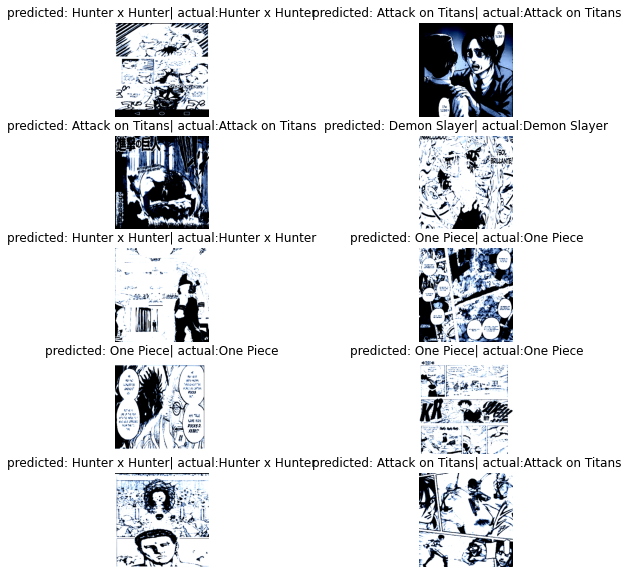

In [26]:
def show_prediction(model , dl, num):
  fig = plt.figure(figsize=(10, 10))
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dl))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for i in range(num):
      ax = plt.subplot(num//2, 2, i+1)
      ax.set_title('predicted: {}| actual:{}'.format(classes[preds[i]], classes[labels[i]]))
      ax.axis('off')
      ax.imshow(inputs.cpu()[i].permute(1, 2 ,0))
  model.train()


show_prediction(model, valid_dl, 10) # implement torchvision.utils.make_grid

We have now achieved a model that can correctly classify the art works with 85 percent accuracy. Now what we really are intrested in is that how did the model achieved such a good result. More specifically, we want to know which features of our images were important to our classification model. In other words, which part of our image activated our model the modest. To do this Pytorch has function called hooks which essentially allows us to implement a function in our forward or backward pass. Using this technique we can regirster a hook in our forward pass and extract the last layer of the convolutional part of the network. then we will visualize the hooked features to understand what where the most important aspects of the picture that made classification possible. for more information on Visualization of the features maps refer to Matt Zeiler and Rob Fergus's [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf) paper. In general as the layers get deeper our model is able to  

In [28]:
# this will show us the module and the name of a the kth layer
k = 0
for name , module in model.named_modules():
  k+= 1
  if k == 113:
    print(module)
    print('-' * 20)
    print(name)
 

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------
layer4.2.conv2


In [22]:
img, label = next(iter(valid_dl))
img = img.to(device)

weights = []
def get_layer(module, input, output):
  weights.append(output)

model.layer4[2].conv2.register_forward_hook(get_layer)




In [25]:
def activated_grid(model, dl, num):
  imgs, lbls = next(iter(dl))
  imgs = imgs.to(device)
  fig = plt.figure(figsize = (8, 8))
  out = model(imgs)
  for i in range(num):
    activated = weights[0][i]
    mean_act = activated.mean(0)
    plt.subplot(1, num, i)
    ax.imshow(imgs[i].cpu().permute(2, 1, 0))
    ax.imshow(mean_act.cpu().detach(), alpha = 0.7, extent=(0, 335, 335, 0), 
              interpolation = 'bilinear', cmap = 'magma' )

activated_grid(model, valid_dl, 5)

RuntimeError: ignored

In [24]:
torch.cuda.empty_cache()

In [21]:
weights

0